# Air Pollution Dataset Preprocessing

In [75]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

from utils import *

datasets_folder = './datasets'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Reading

In [76]:
air_pollution_dataset = os.path.join(datasets_folder,'pollution/pollution.csv')

air_pollution_df = pd.read_csv(air_pollution_dataset, sep=';')
air_pollution_df.rename(columns={
    'COD_STAZ': 'Station', 
    'AGENTE': 'Agent', 
    'DATA_INIZIO': 'Date', 
    'DATA_FINE': 'Ending_date', 
    'VALORE': 'Value', 
    'UM': 'Unit'
}, inplace=True)

air_pollution_df.drop(columns=['Ending_date'], inplace=True)
air_pollution_df=air_pollution_df.sort_values(by='Date')
air_pollution_df['Date'] = pd.to_datetime(air_pollution_df['Date'].apply(lambda x: ' '.join(x.split('T')).split('+')[0]))
air_pollution_df['Date'] = air_pollution_df['Date'].apply(lambda x: x - timedelta(minutes=x.minute)) # round to the hour
air_pollution_df['Agent'] = air_pollution_df['Agent'].apply(lambda x: x.split(' ')[0])

air_pollution_df.head(5)

,Station,Agent,Date,Value,Unit
6726,GIARDINI MARGHERITA,PM2.5,2019-01-01,37.0,ug/m3
8067,GIARDINI MARGHERITA,PM10,2019-01-01,50.0,ug/m3
419631,PORTA SAN FELICE,PM2.5,2019-01-01,41.0,ug/m3
141349,VIA CHIARINI,O3,2019-01-01,0.0,ug/m3
87014,VIA CHIARINI,NO2,2019-01-01,20.0,ug/m3


Let's check the Unit of each agent

In [3]:
air_pollution_df.groupby([ 'Agent','Unit']).size().reset_index(name='counts').drop(columns='counts')

,Agent,Unit
0,C6H6,ug/m3
1,CO,mg/m3
2,NO,ug/m3
3,NO2,ug/m3
4,NOX,ug/m3
5,O3,ug/m3
6,PM10,ug/m3
7,PM2.5,ug/m3


In [77]:
agents = np.unique(air_pollution_df['Agent'])
stations = np.unique(air_pollution_df['Station'])

station_dfs = {s:air_pollution_df[air_pollution_df['Station'] == s] for s in stations}

## Missing Values


Check gaps in the data

In [5]:
s=stations[0]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station GIARDINI MARGHERITA:
 - Agent: NO2


Date,1.0,2.0,3.0,9.0,0.0,5.0,18.0,4.0,43.0,28.0,...,77.0,50.0,16.0,12.0,11.0,10.0,19.0,8.0,7.0,24.0
count,50984,449,23,4,3,3,2,2,2,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: O3


Date,1.0,2.0,3.0,4.0,0.0,49.0,8.0,7.0,18.0,10.0,...,17.0,53.0,11.0,84.0,47.0,25.0,51.0,19.0,31.0,43.0
count,51555,134,20,6,6,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,23.0,25.0,48.0,72.0,96.0,144.0,120.0,192.0
count,2038,12,12,12,11,9,3,2,1


 - Agent: PM2.5


Date,24.0,48.0,23.0,25.0,72.0,96.0,0.0,144.0,120.0
count,2071,13,12,12,6,6,5,3,2


In [6]:
s=stations[1]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station PORTA SAN FELICE:
 - Agent: C6H6


Date,1.0,2.0,3.0,4.0,0.0,5.0,25.0,39.0,9.0,8.0,...,22.0,27.0,17.0,97.0,81.0,48.0,43.0,23.0,40.0,20.0
count,46760,1911,193,17,4,4,3,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: CO


Date,1.0,2.0,3.0,4.0,0.0,6.0,5.0,8.0,14.0,15.0,...,34.0,17.0,42.0,47.0,11.0,7.0,75.0,22.0,170.0,23.0
count,51678,53,23,5,4,4,3,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NO


Date,1.0,2.0,3.0,4.0,6.0,0.0,5.0,24.0,23.0,19.0,...,15.0,8.0,42.0,7.0,11.0,48.0,18.0,34.0,89.0,16.0
count,51072,410,30,8,7,5,4,3,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NO2


Date,1.0,2.0,3.0,4.0,5.0,0.0,6.0,14.0,24.0,25.0,...,37.0,15.0,48.0,42.0,18.0,34.0,19.0,23.0,89.0,12.0
count,51070,409,30,8,6,5,5,2,2,2,...,1,1,1,1,1,1,1,1,1,1


 - Agent: NOX


Date,1.0,2.0,3.0,4.0,6.0,0.0,5.0,24.0,15.0,8.0,...,7.0,11.0,18.0,48.0,42.0,34.0,19.0,23.0,89.0,37.0
count,51197,407,31,8,5,5,4,2,1,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,23.0,25.0,48.0,72.0,96.0,144.0,120.0
count,2093,12,12,8,7,5,2,1


 - Agent: PM2.5


Date,24.0,23.0,25.0,48.0,72.0,96.0,120.0,144.0,0.0
count,2094,12,12,11,8,4,1,1,1


In [7]:
s=stations[2]
print(f'Station {s}:')
for agent in np.unique(station_dfs[s]['Agent']):
    print(f' - Agent: {agent}')
    mask=(station_dfs[s]['Agent']==agent)
    timedeltas_hours = station_dfs[s]['Date'][mask].diff().dt.total_seconds()[1:] / 3600  # Convert to hours
    display(pd.DataFrame(timedeltas_hours.value_counts()).transpose())

Station VIA CHIARINI:
 - Agent: NO2


Date,1.0,2.0,3.0,4.0,0.0,5.0,7.0,8.0,6.0,12.0,25.0,10.0,21.0,17.0,26.0,31.0,30.0,70.0,39.0,15.0
count,51121,470,28,9,8,6,3,3,3,2,2,1,1,1,1,1,1,1,1,1


 - Agent: O3


Date,1.0,2.0,3.0,4.0,0.0,5.0,8.0,6.0,14.0,7.0,...,28.0,17.0,26.0,13.0,9.0,30.0,70.0,23.0,12.0,25.0
count,51117,386,16,8,6,4,3,2,2,1,...,1,1,1,1,1,1,1,1,1,1


 - Agent: PM10


Date,24.0,48.0,23.0,25.0,72.0,96.0,192.0,120.0,144.0,168.0
count,2065,16,12,12,5,4,2,2,1,1


### Resampling

Resample (modify dataframe to have a dense index and add also to each row the missing values for station and Unit(not really necessary anyway))
PM are resampled at 24h, other agents at 1h

In [ ]:
agents_dict = {
    'PM10': '24h',
    'PM2.5': '24h',
    'CO': '1h',
    'O3': '1h',
    'NO': '1h',
    'NO2': '1h',
    'NOX': '1h',
    'C6H6': '1h'
}

resampled_san_felice_df = resample_df_on_column(station_dfs[stations[1]], agents_dict)
resampled_san_felice_df[resampled_san_felice_df['Agent'] == 'NO2'].head()


Added the missing rows but still the value is Nan

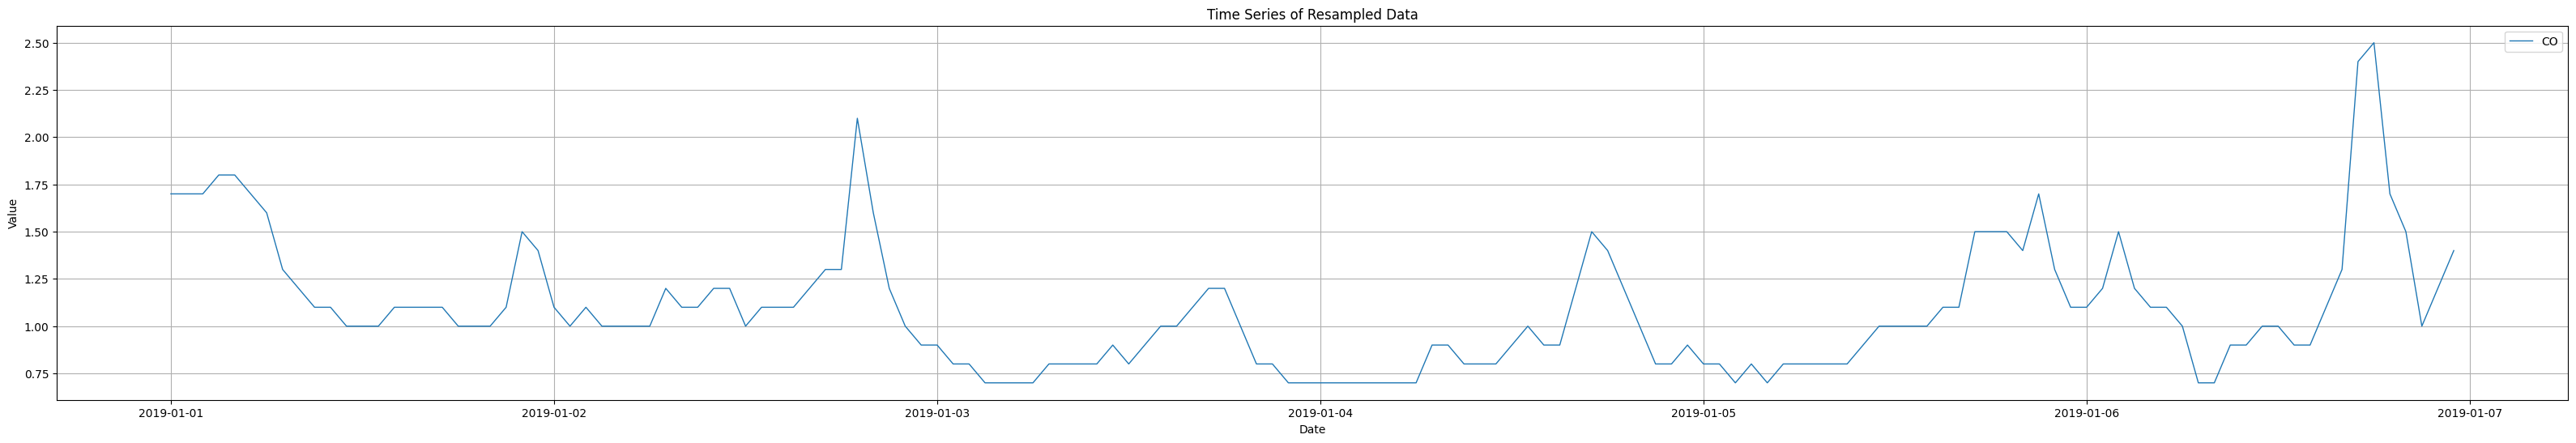

In [ ]:
start_date=datetime(2019,1,1)
end_date=datetime(2019,1,7)

to_plot = resampled_san_felice_df[resampled_san_felice_df['Agent']=='CO']

# plot_time_series([giardini_df[giardini_df['Agent']=='CO']], 'Value', 'Date', legends=['CO'], start_date=start_date, end_date=end_date, title='Original Data')
plot_time_series([to_plot], 'Value', 'Date', legends=['CO'], start_date=start_date, end_date=end_date, title='Resampled Data')

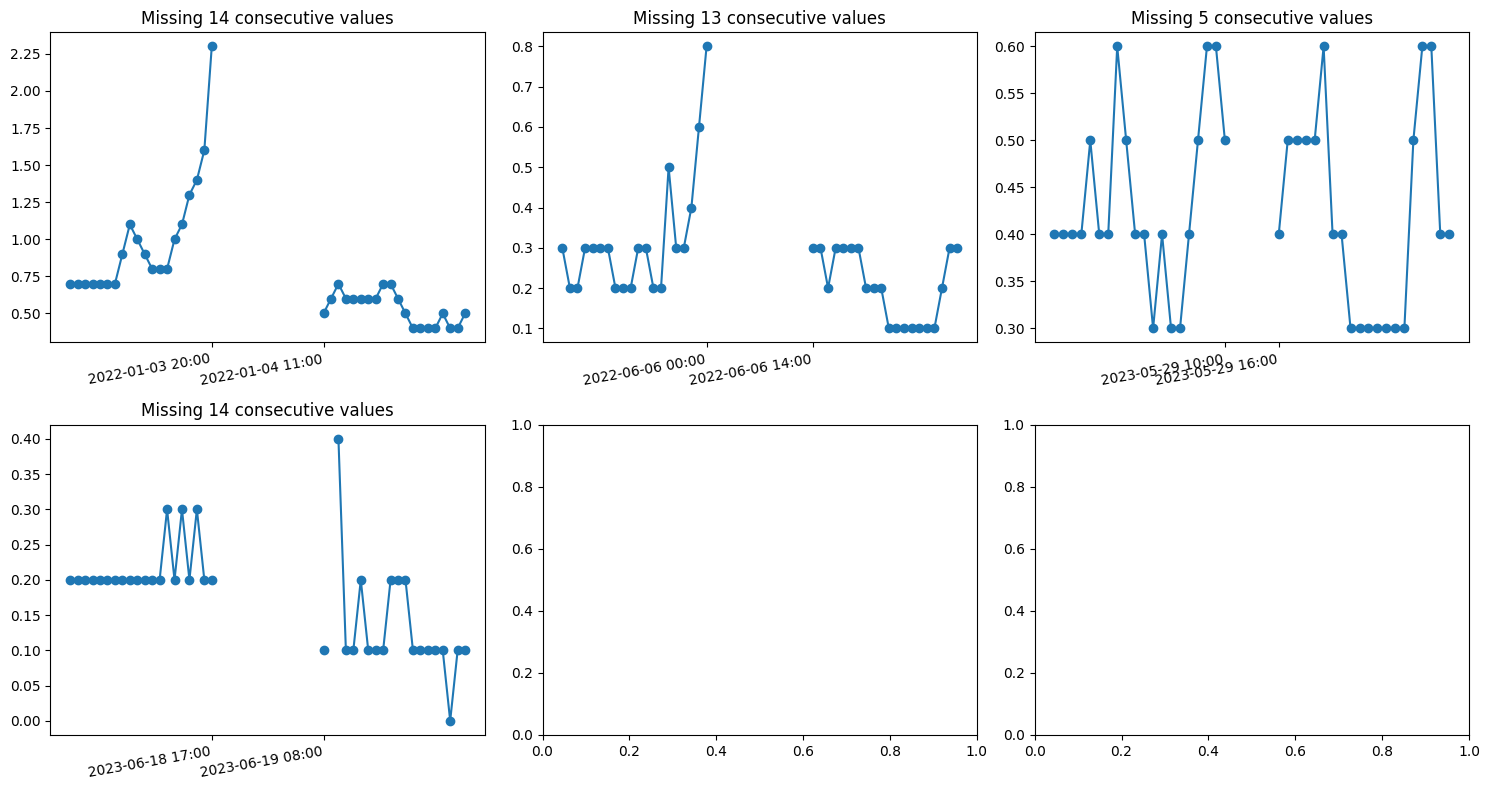

In [ ]:
start_date=datetime(2022,1,1)
end_date=datetime(2025,1,1)

# display the gaps of at lest 5 hours of NO2
plot_missing_value_gaps(to_plot,start_date=start_date, end_date=end_date,
                         min_gap=5, surrounding_vals=20)

Check the amount of missing data for each agent.

In [12]:
for agent in np.unique(resampled_san_felice_df['Agent']):
    count = resampled_san_felice_df[resampled_san_felice_df['Agent']==agent].isna().sum()['Value']
    tot = len(resampled_san_felice_df[resampled_san_felice_df['Agent']==agent])
    print(f'Agent {agent}: {count}({count/tot:.4f}%) missing Values')

Agent C6H6: 3675(0.0699%) missing Values
Agent CO: 821(0.0156%) missing Values
Agent NO: 1056(0.0201%) missing Values
Agent NO2: 1056(0.0201%) missing Values
Agent NOX: 940(0.0179%) missing Values
Agent PM10: 57(0.0260%) missing Values
Agent PM2.5: 54(0.0246%) missing Values


## Filling Missing Values

Even if the data missing is small, oftentimes they create a big gap of missing values. We will try to reconstruct it to a somewhat reasonable behaviour.

### Full Process

For each agent, we train a model to reconstruct the missing values.

#### Time Period

the prof had 5 min sampling and used 8 days... we have 60 minutes so... 3 months (?)

Looking at the plots, most of 2023 and 2024 havent got big gaps, but also early 2019/2023 and late 2022. Let's try november 2022 to february 2023.

Edit: mi sa non bastano?? allungo un po


In [13]:
start = datetime(2022,4,5,8)
end = datetime(2022,6,30)
end-start

datetime.timedelta(days=85, seconds=57600)

We are going to work with NO2 data.

In [14]:
resampled_giardini_df['Date_idx'] = np.arange(len(resampled_giardini_df))

NameError: name 'resampled_giardini_df' is not defined

In [ ]:
segment = resampled_giardini_df[(resampled_giardini_df['Agent']=='NO2')&(resampled_giardini_df['Date']>=start)&(resampled_giardini_df['Date']<end)]
display(segment.isna().sum())
# display(segment)

Date         0
Station      0
Agent        0
Value       24
Unit         0
Date_idx     0
dtype: int64

#### Train and Test set

The segment has only 4 missing values, so we choose a good period... Let's drop these rows and prepare a training and test set.

In [ ]:
tmp = segment.copy()
tmp = tmp.dropna()
tmp

,Date,Station,Agent,Value,Unit,Date_idx
28568,2022-04-05 08:00:00,GIARDINI MARGHERITA,NO2,10.0,ug/m3,28568
28569,2022-04-05 09:00:00,GIARDINI MARGHERITA,NO2,7.0,ug/m3,28569
28570,2022-04-05 10:00:00,GIARDINI MARGHERITA,NO2,10.0,ug/m3,28570
28571,2022-04-05 11:00:00,GIARDINI MARGHERITA,NO2,12.0,ug/m3,28571
28572,2022-04-05 12:00:00,GIARDINI MARGHERITA,NO2,12.0,ug/m3,28572
...,...,...,...,...,...,...
30619,2022-06-29 19:00:00,GIARDINI MARGHERITA,NO2,4.0,ug/m3,30619
30620,2022-06-29 20:00:00,GIARDINI MARGHERITA,NO2,5.0,ug/m3,30620
30621,2022-06-29 21:00:00,GIARDINI MARGHERITA,NO2,5.0,ug/m3,30621
30622,2022-06-29 22:00:00,GIARDINI MARGHERITA,NO2,5.0,ug/m3,30622


In [ ]:
np.random.seed(42)
idx = np.arange(len(tmp))
np.random.shuffle(idx[1:-1]) # do not shuffle the first/last point
t = idx[1]; idx[1] = idx[-1]; idx[-1] = t # keep first/last points in the left half (??????????????????????????????????????????????????????????????????????????)

split=0.8 # maybe a bit more than 2/3 since that there are little missing values? 
sep = int(len(idx) * split)
train_data = tmp.iloc[idx[:sep]]
test_data = tmp.iloc[idx[sep:]]

In [ ]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm

figsize=(20,4)

#### First kernel

In [ ]:
kernel = WhiteKernel(1e-3, (1e-4, 1e2))
kernel += ConstantKernel(1, (1e-2, 5e3)) * RBF(1, (1e-1, 1e1))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(train_data[['Date_idx']], train_data['Value'])
print(gp.kernel_)

WhiteKernel(noise_level=11.2) + 24.8**2 * RBF(length_scale=5.97)


In [ ]:
pred, std = gp.predict(segment[['Date_idx']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

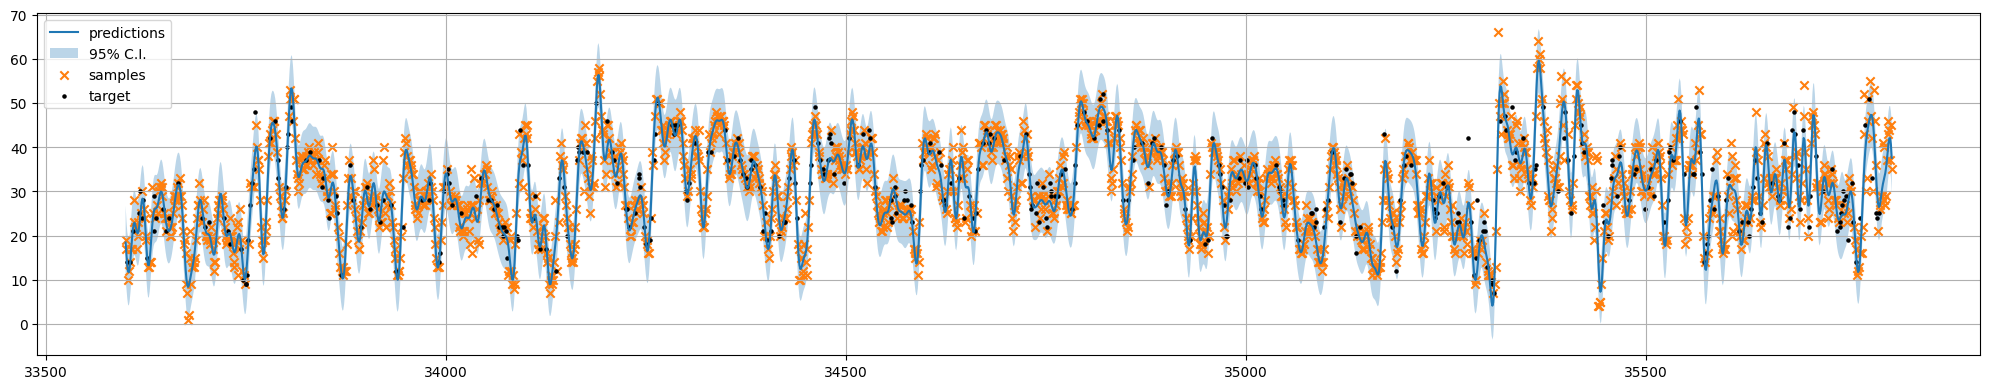

In [ ]:
plot_gp(target_samples=test_data['Value'], samples=train_data['Value'], pred=pred, std=std, figsize=figsize)

In [ ]:
# Obtain predictions for the validation data
pred_ts = pred[test_data.index]
std_ts = std[test_data.index]

ldens = norm.logpdf(test_data['Value'], pred_ts, std_ts)
ll = np.sum(ldens)
print(f'Log likelihood of the validation set: {ll:.2f}')

Log likelihood of the validation set: -1081.20


#### Second Kernel

In [ ]:
kernel = WhiteKernel(1e-3, (1e-4, 1e2))
kernel += ConstantKernel(1, (1e-2, 1e3)) * RBF(1, (1e-1, 1e1))
kernel += ConstantKernel(1, (1e-2, 1e3)) * ExpSineSquared(1, 2000, (1e-1, 1e1), (900, 2100))

np.random.seed(42)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)
gp.fit(train_data[['Date_idx']], train_data['Value'])
print(gp.kernel_)

WhiteKernel(noise_level=2.51) + 6.67**2 * RBF(length_scale=1.68) + 11**2 * ExpSineSquared(length_scale=9.62, periodicity=1.03e+03)


In [ ]:
pred, std = gp.predict(segment[['Date_idx']], return_std=True)
pred = pd.Series(index=segment.index, data=pred)
std = pd.Series(index=segment.index, data=std)

Log likelihood of the validation set: -966.11


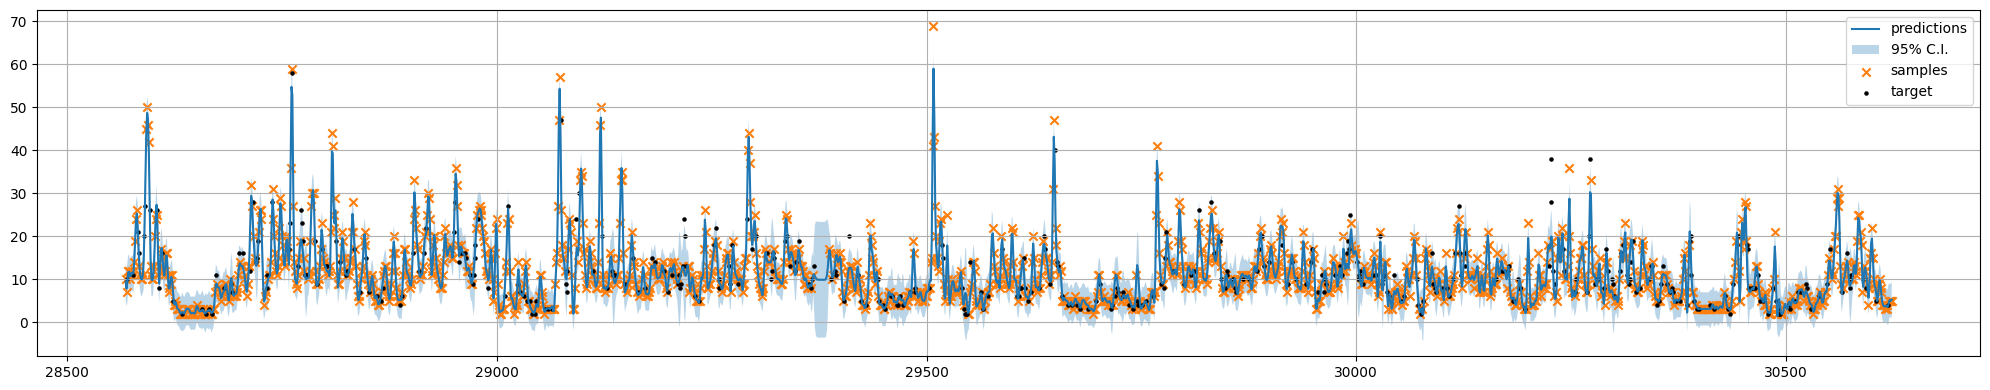

In [ ]:
plot_gp(target_samples=test_data['Value'], samples=train_data['Value'], pred=pred, std=std, figsize=figsize)
ldens = norm.logpdf(test_data['Value'], pred[test_data.index], std[test_data.index])
print(f'Log likelihood of the validation set: {np.sum(ldens):.2f}')

#### sezione strana sulla std

#### Full data filling

***NOTE** : just NO2*

In [ ]:
start_date=datetime(2022,3,20)
end_date=datetime(2022,4,30)

no2_df = resampled_giardini_df[(resampled_giardini_df['Agent']=='NO2')&(resampled_giardini_df['Date']>=start_date)&(resampled_giardini_df['Date']<=end_date)]
len(no2_df)

985

In [ ]:
gp2 = GaussianProcessRegressor(kernel=gp.kernel_, optimizer=None)
tmp = no2_df.dropna() # The whole series (NaNs excluded)
gp2.fit(tmp[['Date_idx']], tmp['Value'])
pred_all, std_all = gp2.predict(no2_df[['Date_idx']], return_std=True)
pred_all = pd.Series(index=no2_df.index, data=pred_all)
std_all = pd.Series(index=no2_df.index, data=std_all)

predictions :(

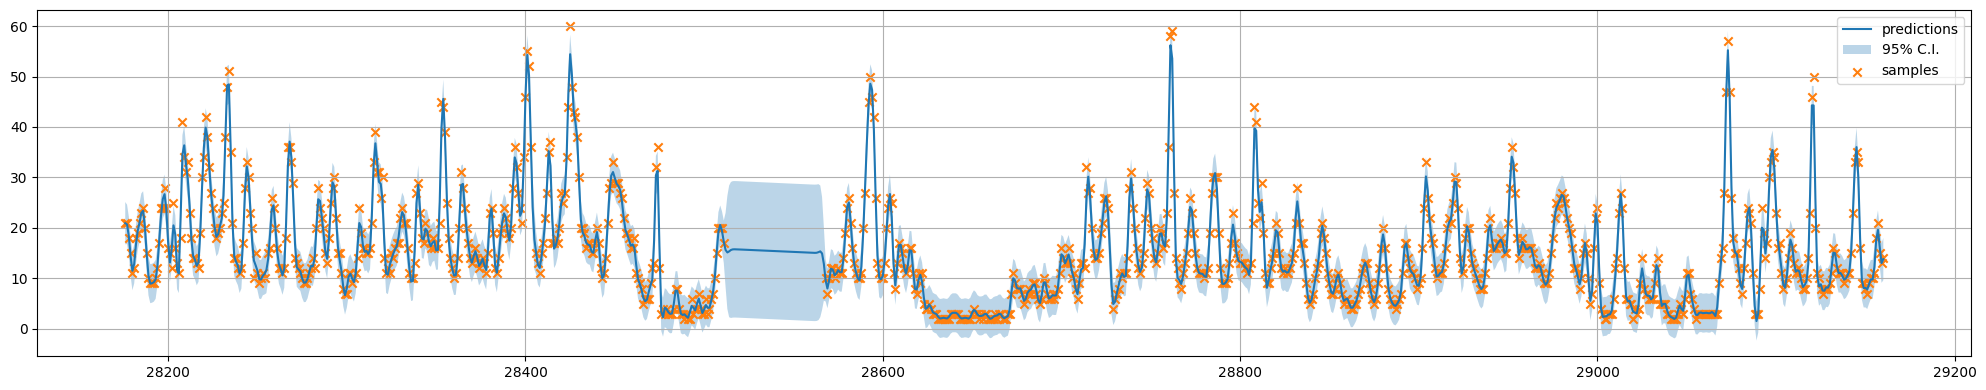

In [ ]:
plot_gp(samples=no2_df['Value'], pred=pred_all, std=std_all, figsize=figsize)

### Final Function

In [ ]:
model = {
    
}

filled_giardini_df = fill_missing_dates_on_column_value(resampled_giardini_df, column_to_fill='Value', mode='model', model_settings=model)
filled_giardini_df.isna().sum()

In [ ]:
agent_dfs = df_to_agents_dict(filled_giardini_df)

Splitting station "GIARDINI MARGHERITA"...


## **AQI**

For each station we develop a model to describe the air pollution. Given that each station collects different data, and sometimes with different intensities, we decided to treat each station indepentendtely.

Air polution follows this criteria:
- for each pollutant a certain limit is defined (like 25 µg/m³ for PM2.5)
- for each pollutant $ AQI = \frac{Concentration}{Limit} \times 100 $
- take the maximum value across all the IQAs 

The overage value is then matched on the following table:

| **AQI**         | **CONDITIONS** |
| --------------- | -------------- |
| <30             | EXCELLENT      |
| From 34 to 66   | GOOD           |
| From 67 to 99   | FAIR           |
| From 99 to 150  | POOR           |
| >150            | VERY POOR      |

We are going to model each agent to predict its hour value and then use all of the predictions to compute the overall Air Quality Index and compare it with the one got from the readings.

<table class="pure-table legenda">
    <thead>
        <tr class="main"><th colspan="5">Limiti di riferimento per gli inquinanti monitorati (D.Lgs.155/2010)</th></tr>
        <tr>
            <th>Inquinante</th>
            <th>Limite</th>
            <th>Periodo di mediazione</th>
            <th>Limite</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>PM10 (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite giornaliero</td>
            <td data-column="Media">Media giornaliera</td>
            <td data-column="Limite">50 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Biossido di azoto">NO<sub>2</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite orario</td>
            <td data-column="Media">Media oraria</td>
            <td data-column="Limite">200 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td rowspan="3"><abbr title="Ozono">O<sub>3</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Soglia d'informazione</td>
            <td data-column="Media">Media oraria</td>
            <td data-column="Limite">180 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>Soglia d'allarme</td>
            <td data-column="Media">Media oraria</td>
            <td data-column="Limite">240 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>Valore obiettivo</td>
            <td data-column="Media">Massima delle medie mobili su 8 ore</td>
            <td data-column="Limite">120 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Monossido di carbonio">CO</abbr> (mg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite</td>
            <td data-column="Media">Massima delle medie mobili su 8 ore</td>
            <td data-column="Limite">10 mg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td><abbr title="Biossido di zolfo">SO<sub>2</sub></abbr> (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite giornaliero</td>
            <td data-column="Media">Media giornaliera</td>
            <td data-column="Limite">125 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>PM2.5 (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite su base annua</td>
            <td data-column="Media">Media giornaliera</td>
            <td data-column="Limite">25 µg/m<sup>3</sup></td>
        </tr>
        <tr>
            <td>Benzene (µg/m<sup>3</sup>)</td>
            <td data-column="Limite">Valore limite su base annua</td>
            <td data-column="Media">Media giornaliera</td>
            <td data-column="Limite">5 µg/m<sup>3</sup></td>
        </tr>
    </tbody>
</table>

*source: [ARPAE](https://apps.arpae.it/qualita-aria/bollettino-qa-provinciale/bo)*

### Agents

Let's inspect our agents:

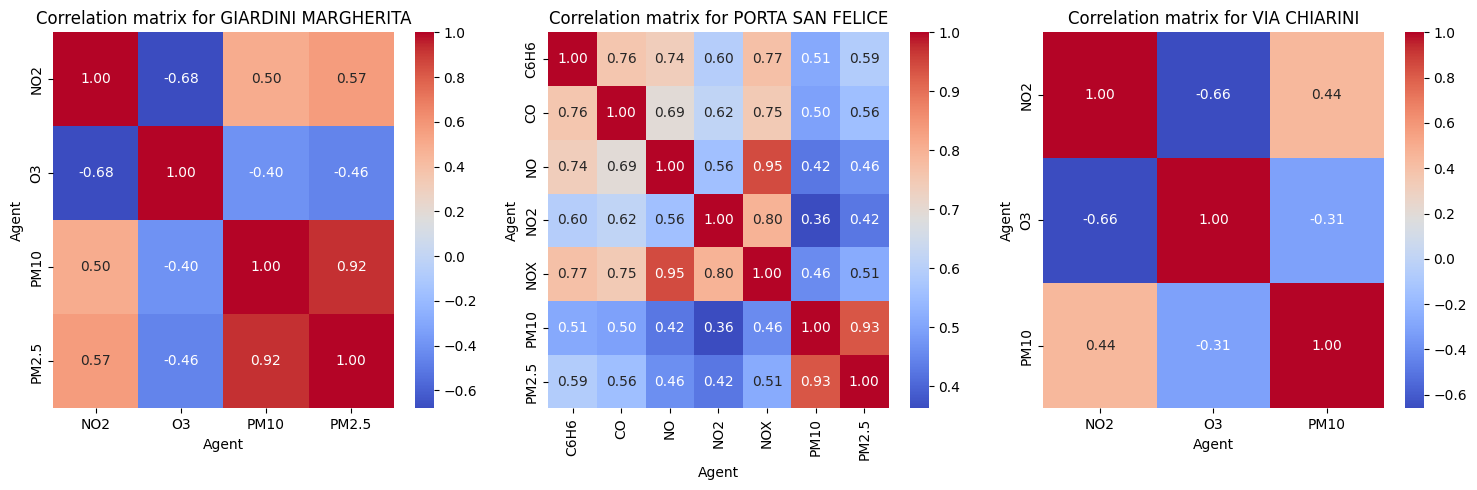

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, s in enumerate(stations):
    corr_matrix = station_dfs[s].pivot_table(index='Date', columns='Agent', values='Value').corr()
    axes[i].set_title(f'Correlation matrix for {s}')
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[i])

plt.tight_layout()
plt.show()

In the AQI standard NO and NOX are not present. NOX is simply a short-hand for both NO and NO2, in fatcs it is higly correlated with both of them. We can safely drop it because it is not useful and we already have its informations.

Even if NO is different form NO2, it is not used to predict the Air Quality Index, so we choose to ignore it in outr models.

In [79]:
for s in stations:
    station_dfs[s] = station_dfs[s][~station_dfs[s]['Agent'].isin(['NO','NOX'])]

### Visualization

In [80]:
pollutant_limits = {
    'PM2.5': 25,    # µg/m³
    'PM10': 50,     # µg/m³
    'CO': 10,       # mg/m³
    'O3': 180,      # µg/m³
    'NO2': 200,     # µg/m³
    'C6H6': 5       # µg/m³
}

In [82]:
station_dicts = [df_to_agents_dict(station_dfs[s].drop(columns=['Unit']), drop_agents=True, drop_stations=True) for s in stations]
for dict,name in zip(station_dicts,stations):
    print(f'Station {name} agents:',end='\n -')
    print(*list(dict.keys()),sep=',')

Splitting station "GIARDINI MARGHERITA"...
Splitting station "PORTA SAN FELICE"...
Splitting station "VIA CHIARINI"...
Station GIARDINI MARGHERITA agents:
 -NO2,O3,PM10,PM2.5
Station PORTA SAN FELICE agents:
 -C6H6,CO,NO2,PM10,PM2.5
Station VIA CHIARINI agents:
 -NO2,O3,PM10


For each station construct the daily and hourly AQI for each agent.

In [216]:
station_AQIs_daily = [
    {agent: get_AQI(station_dict[agent], agent=agent, limit=pollutant_limits[agent], period='day', value_column='Value').iloc[30*7+20:30*8+10] for agent in station_dict.keys()} for station_dict in station_dicts
]

station_AQIs_hourly = [
    {agent: get_AQI(station_dict[agent], agent=agent, limit=pollutant_limits[agent], period='hour', value_column='Value').iloc[5000:(5000 + 3)] for agent in station_dict.keys()} for station_dict in station_dicts
]

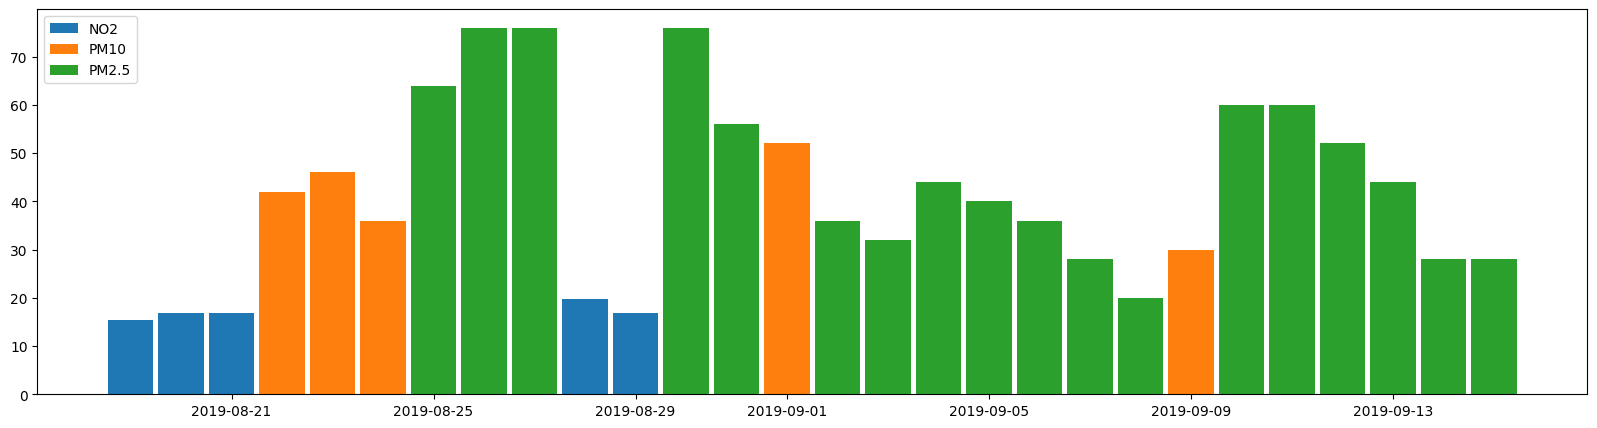

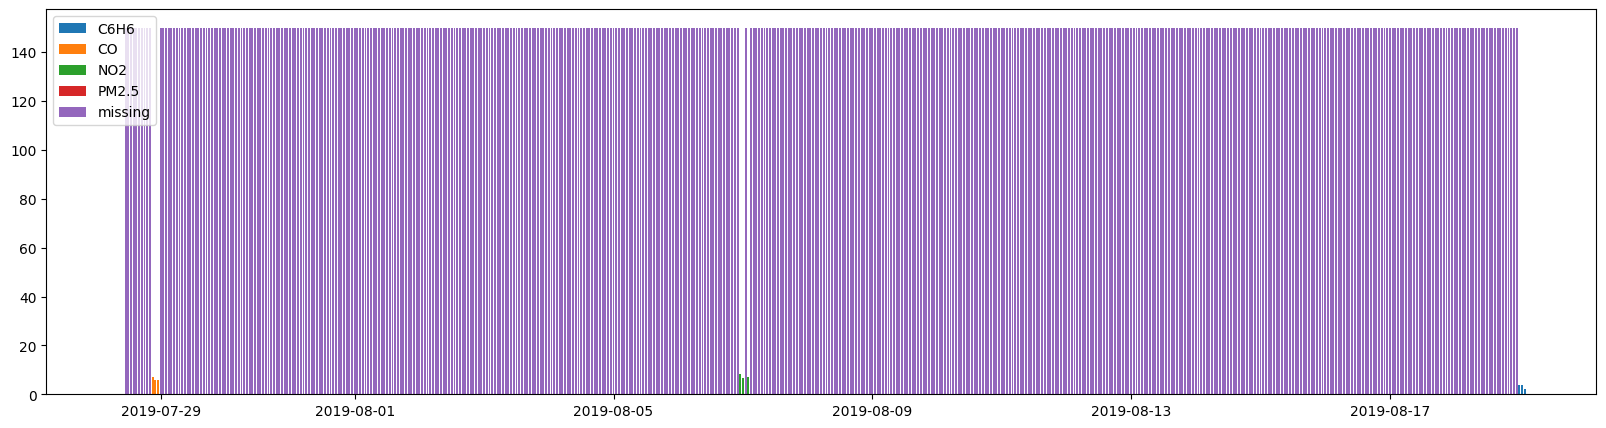

In [217]:
plot_AQI(station_AQIs_daily[1], period='day')
plot_AQI(station_AQIs_hourly[1], period='hour')